In [20]:
import itertools
import shutil
from pathlib import Path

import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import polars as pl
import tqdm
from scipy import stats
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def select_cols(num_cols: int) -> list[pl.Expr]:
    return [pl.col(f"column_{i}") for i in range(num_cols)]

In [22]:
csv_path = Path("/home/shinsei/MyResearches/feat_extrc/reports/features/"
                "SimpleCAE64/2024-02-06/16-17-13/features_check_data.csv")
df = pl.read_csv(csv_path)
n_lf = 16
X = df.select(select_cols(n_lf))
sample_nums = df.select(["dirname"]).to_numpy().flatten()

sc = StandardScaler()
X_std = sc.fit_transform(X)


The number of dimensions after reduced is 10.


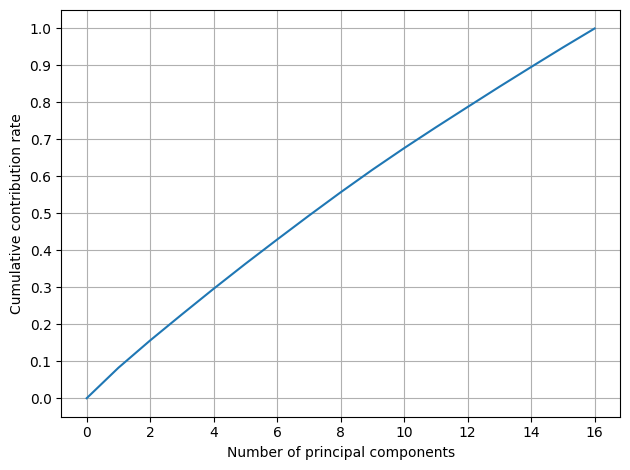

In [6]:
pca = PCA()
X_pca = pca.fit_transform(X_std)

cumsum_contrb_rate = pca.explained_variance_ratio_.cumsum()
num_dims_after_reduced = cumsum_contrb_rate[cumsum_contrb_rate < 0.7].shape[0]
print(f"The number of dimensions after reduced is {num_dims_after_reduced}.")

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(X.shape[1]+1), [0]+list(cumsum_contrb_rate))
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Cumulative contribution rate')
ax.set_yticks(np.arange(0., 1.1, 0.1))
ax.grid()
fig.tight_layout()
plt.show()


In [13]:
X_pca_redc = X_pca[:, :num_dims_after_reduced]

ocsvm_pca = svm.OneClassSVM(
)
ocsvm_pca.fit(X_pca_redc)

OneClassSVM()

In [8]:
ocsvm = svm.OneClassSVM()
ocsvm.fit(X)


OneClassSVM()

In [15]:
y_pred = ocsvm.predict(X)
y_pca_pred = ocsvm_pca.predict(X_pca_redc)
np.sum(y_pred == y_pca_pred)

-4

In [29]:
all(y_pred == y_pca_pred)

False

In [32]:
list(y_pred == y_pca_pred).count(False)

7826

In [28]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([19752, 19749]))

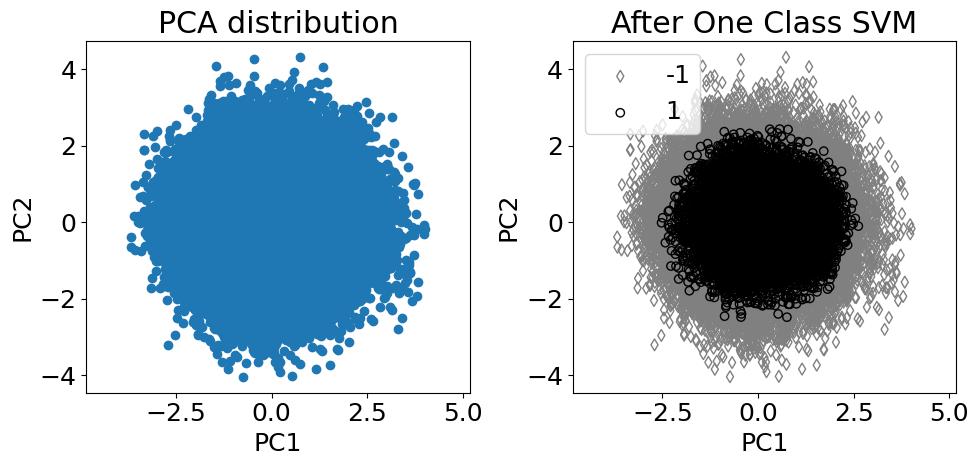

In [14]:
fig = plt.figure(figsize=(10, 5))
plt.rcParams["font.size"] = 18

x_axis = 0
y_axis = 1

ax = fig.add_subplot(1,2,1)
ax.scatter(X_pca_redc[:, x_axis], X_pca_redc[:, y_axis])
ax.set_aspect("equal", "datalim")
ax.set_title("PCA distribution")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

ax = fig.add_subplot(1,2,2)
ax.scatter(
    X_pca_redc[y_pca_pred==-1, x_axis],
    X_pca_redc[y_pca_pred==-1, y_axis],
    edgecolors="gray",
    marker="d",
    facecolor="None",
    label="-1"
)
ax.scatter(
    X_pca_redc[y_pca_pred==1, x_axis],
    X_pca_redc[y_pca_pred==1, y_axis],
    edgecolors="black",
    marker="o",
    facecolor="None",
    label="1"
)
ax.legend()
ax.set_aspect("equal", "datalim")
ax.set_title("After One Class SVM")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

fig.tight_layout()
# fig.savefig("../reports/figures/OneClassSVM/2024-02-05/ocsvm_64px_128lf.png",
#             bbox_inches="tight")
plt.show()

In [16]:
df.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,dirname,filename
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.75505,1.185517,0.670952,0.529529,0.602238,0.825177,1.128805,0.771469,0.444369,0.947627,1.047657,1.163484,1.559615,0.900038,1.504516,1.00981,0,"""10k_0_h000_w00…"
1.116155,0.830559,0.662566,1.202467,0.875695,0.701722,0.678753,1.152239,0.587595,0.860536,0.694376,1.392805,1.25608,0.577492,1.424431,0.831488,0,"""10k_0_h000_w00…"
0.8952,0.781401,1.013736,1.039714,0.784608,1.099659,1.209714,1.328835,1.108849,0.361259,1.014879,1.019658,1.368682,0.704367,1.412786,0.650062,0,"""10k_0_h000_w00…"
1.121443,0.306462,0.942129,0.744235,0.973183,1.013571,0.568486,1.040651,0.407283,0.782389,1.51786,1.123604,1.058231,0.881189,0.793165,0.696223,0,"""10k_0_h000_w00…"
0.960935,1.08539,1.3532,1.112571,0.897042,0.567075,1.240956,0.927499,1.212662,1.394874,1.056652,1.042374,0.86041,0.547025,1.268081,0.751208,0,"""10k_0_h000_w00…"


In [17]:
labeled_df = df.select(
    pl.concat_str(pl.col("dirname"), pl.col("filename"), separator="/")
    .alias("filepath")
).with_columns(
    pl.Series("cluster", y_pca_pred)
)

In [26]:
# source = Path("../data/processed/check/CNTForest/cnt_sem_for_check_64x64/10k")
source = Path("../data/processed/CNTForest/cnt_sem_64x64/10k")
for label in np.unique(y_pca_pred):
    sampled_df = labeled_df.filter(
        pl.col("cluster") == label
    ).sample(10)
    sampled_df.get_column("filepath").apply(
        lambda path: shutil.copyfile(source / path, f"../reports/figures/OneClassSVM/scale_nu0.5/label_{label}/{Path(path).name}")
    )
sampled_df.get_column("filepath")[0]

'4/10k_4_h032_w0256.png'

In [ ]:
hyper_params: dict[str, str | int | float] = {
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
}

In [ ]:
class NtimesOCSVM:
    def __init__(self, num_divs: int = 1, **kwargs) -> None:
        """_summary_

        Parameters
        ----------
        num_divs : int, optional
            _description_, by default 2
        """
        self.num_divs = num_divs
        self.ocsvms: list[svm.OneClassSVM] = [
            svm.OneClassSVM(kwargs) for i in range(self.num_divs)
        ]

    def fit(self, x: npt.NDArray, verbose: bool = False) -> None:
        if verbose:
            for ocsvm in tqdm.tqdm(self.ocsvms):
                y = ocsvm.fit_predict(x)
                x = x[y == 1]
        else:
            for  ocsvm in self.ocsvms:
                y = ocsvm.fit_predict(x)
                x = x[y == 1]

    def fit_pred(self, x: npt.NDArray, verbose: bool = False) -> npt.NDArray:
        self.fit(x, verbose)
        clusters: list[int] = []
        pass

    def pred(self, x: npt.NDArray) -> npt.NDArray:
        labels = np.full_like(x, -1)

        for i, ocsvm in enumerate(self.ocsvms):
            y_tmp = ocsvm.predict(x[labels == -1])
            outlier = np.argmin(y_tmp) == 0
            labels[labels == -1][outlier] = i


        return


In [4]:
import numpy as np
rng = np.random.default_rng(42)
labels = np.full((10,), -1)
for n in range(4):
    print(labels)
    y_tmp = rng.integers(0, 2, np.sum(labels==-1))
    # labels[labels==-1][y_tmp==0] = n
    labels = np.where(y_tmp==0, n, labels)

print(labels)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 0 -1 -1  0  0 -1  0 -1  0  0]


ValueError: operands could not be broadcast together with shapes (4,) () (10,) 

In [16]:
class OCSVMHyperParams:
    """Hyper parameters at OneClassSVM

    """
    def __init__(self, n) -> None:
        self.kernels: list[str] = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
        self.degrees: list[int] = list(range(2, 5))
        self.gammas: list[str] = ["scale", "auto"]
        self.coef0s: list[float] = list(map(lambda x: 0.1 * float(x), range(1, 10)))

        self.combination = itertools.product(
            self.kernels,
            self.degrees,
            self.gammas,
            self.coef0s,
        )
        self.step = len(self.combination)


TypeError: iter() returned non-iterator of type 'OCSVMHyperParams'

In [ ]:
# Example settings
n_samples = 400
outliers_fraction = 0.05
clusters_separation = [0, 1, 2]
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))


In [ ]:
# 正常データと異常データの生成
n_inliers = int((1.0 - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = 0


In [ ]:
np.random.randn(2,3)

In [ ]:
# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    rng = np.random.default_rng(42)
    x1 = rng.normal(loc=-offset, scale=0.3, size=(int(0.25 * n_inliers), 2))
    x2 = rng.normal(loc=+offset, scale=0.3, size=(int(0.25 * n_inliers), 2))

    x3 = np.c_[
        rng.normal(loc=-3 * offset, scale=0.3, size=(int(0.25 * n_inliers), 1)),
        rng.normal(loc=+3 * offset, scale=0.3, size=(int(0.25 * n_inliers), 1))
    ]

    x4 = np.c_[
        rng.normal(loc=+3 * offset, scale=0.3, size=(int(0.25 * n_inliers), 1)),
        rng.normal(loc=-3 * offset, scale=0.3, size=(int(0.25 * n_inliers), 1))
    ]

    x = np.r_[x1, x2, x3, x4]
    x = np.r_[x, rng.uniform(low=-6, high=6, size=(n_outliers, 2))]

    plt.figure(figsize=(10, 12))

    nu_l = [0.05, 0.1, 0.5]
    for j, nu in enumerate(nu_l):
        clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma="auto")
        clf.fit(x)
        y_pred = clf.decision_function(x).ravel()
        threshold = stats.scoreatpercentile(y_pred, 100 * outliers_fraction)
        y_pred_tf = y_pred > threshold
        n_errors = (y_pred_tf != ground_truth).sum()

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 3, i * 3 + j + 1)
        subplot.set_title("Outlier detection nu=%s" % nu)
        # 予想結果
        subplot.contourf(
            xx,
            yy,
            Z,
            levels=np.linspace(Z.min(), threshold, 7),
            cmap=plt.cm.Blues_r
        )
        # 超平面
        a = subplot.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors="red")
        # 正常範囲
        subplot.contourf(
            xx,
            yy,
            Z,
            levels=[threshold, Z.max()],
            color="orange",
        )
        # 正常データ
        b = subplot.scatter(
            x[:-n_outliers, 0],
            x[:-n_outliers, 1],
            color="white",
        )
        # 異常データ
        c = subplot.scatter(
            x[-n_outliers:, 0],
            x[-n_outliers:, 1],
            color="black",
        )
        subplot.axis("tight")
        subplot.legend(
            [a.collections[0], b, c],
            ["learned decision function", "true inliers", "true outliers"],
            prop=matplotlib.font_manager.FontProperties(size=11),
        )
        subplot.set_xlabel(f"{i + 1}. One Class SVM (errors: {n_errors})")
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
        plt.subplots_adjust(0.04, 0.1, 1.2, 0.84, 0.1, 0.26)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from scipy import stats

from sklearn import svm
from sklearn.covariance import EllipticEnvelope

# Example settings
n_samples = 400 # 標本数
outliers_fraction = 0.05 # 全標本数のうち、異常データの割合
clusters_separation = [0, 1, 2]
# ２次元作図用格子状データの生成
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))

# 正常データと異常データの生成
n_inliers = int((1. - outliers_fraction) * n_samples) # 正常データの標本数
n_outliers = int(outliers_fraction * n_samples) # 異常データの標本数
ground_truth = np.ones(n_samples, dtype=int) # ラベルデータ
ground_truth[-n_outliers:] = 0

# Fit the problem with varying cluster separation
# [enumerate関数](http://python.civic-apps.com/zip-enumerate/)はインデックスとともにループする
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # 正常データ生成
    X1 = 0.3 * np.random.randn(int( 0.25 * n_inliers ), 2) - offset # 正規分布 N(μ= -offset, σ=0.3)
    X2 = 0.3 * np.random.randn(int( 0.25 * n_inliers ), 2) + offset # 正規分布 N(μ= +offset, σ=0.3)

    X3 = np.c_[
            0.3 * np.random.randn(int( 0.25 * n_inliers ), 1) - 3*offset, # 正規分布 N(μ= -3*offset, σ=0.3)
            0.3 * np.random.randn(int( 0.25 * n_inliers ), 1) + 3*offset  # 正規分布 N(μ= +3*offset, σ=0.3)
        ]

    X4 = np.c_[
            0.3 * np.random.randn(int( 0.25 * n_inliers ), 1) + 3*offset, # 正規分布 N(μ= +3*offset, σ=0.3)
            0.3 * np.random.randn(int( 0.25 * n_inliers ), 1) - 3*offset  # 正規分布 N(μ= -3*offset, σ=0.3)
        ]

    X = np.r_[X1, X2, X3, X4] # 行で結合
    # 外れ値データ生成
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))] # 一様分布 -6 <= X <= +6

        # Fit the model with the One-Class SVM
    plt.figure(figsize=(10, 12))
    # 外れ値検知のツール、１クラスSVMとRobust Covariance Estimator
#    classifiers = {
#    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
#                                     kernel="rbf", gamma=0.1),
#    "robust covariance estimator": EllipticEnvelope(contamination=.1)} # 共分散推定
    nu_l = [0.05, 0.1, 0.5]
    for j, nu in enumerate(nu_l):
#    clf = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1)
        clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma='auto')
        clf.fit(X)
        y_pred = clf.decision_function(X).ravel() # 各データの超平面との距離、ravel()で配列を1D化
        threshold = stats.scoreatpercentile(y_pred, 100 * outliers_fraction) # パーセンタイルで異常判定の閾値設定
        y_pred = y_pred > threshold
        n_errors = (y_pred != ground_truth).sum() # 誤判定の数

        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) # 格子状に超平面との距離を出力
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 3,i*3+j+1)
        subplot.set_title("Outlier detection nu=%s" % nu)
        # 予測結果
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
        # 超平面
        a = subplot.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
        # 正常範囲
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
        # 正常データ
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        # 異常データ
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11))
    #    subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlabel("%d. One class SVM (errors: %d)" % (i+1, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
        plt.subplots_adjust(0.04, 0.1, 1.2, 0.84, 0.1, 0.26)

plt.show()
